In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, train_window, Window

In [2]:
class CoreDataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, lags: int, series: str):
        # start from 1948
        core: pd.DataFrame = df[["CPIAUCSL", "UNRATE", "A191RO1Q156NBEA"]].loc["1948-01-01":]
        
        X = get_lags(core, lags)
        self.y = core[lags:][series].values
        self.X = X[lags:].values
        
    def __getitem__(self, index):
        return self.y[index], self.X[index]
    
    def __len__(self):
        return len(self.y)
    
    def plot(self):
        plt.plot(self.core)
        plt.show()

full = pd.read_csv('growth_rate.csv', index_col=0, header=[0], parse_dates=True)
cpidata = CoreDataset(full, lags=3, series="CPIAUCSL")
gdpdata = CoreDataset(full, lags=3, series="A191RO1Q156NBEA")
uedata = CoreDataset(full, lags=3, series="UNRATE")

In [3]:
def generate_window(dataset: Dataset):
    windows = []
    train_size = 400
    val_size = 100
    test_from = 700
    train_start = 0
    
    # reserve test set first
    testset = Subset(dataset, [i for i in range(test_from + 1, len(dataset))])
    testloader = DataLoader(testset, batch_size=1, shuffle=False, sampler=SequentialSampler(testset))
    
    # generate training windows
    while train_start + train_size + val_size <= test_from:
        train_end = train_start + train_size
        print("Generating training set from: %d to %d" % (train_start, train_end))
        trainset = Subset(dataset, [i for i in range(train_start, train_end)])
        
        val_start = train_end + 1
        val_end = train_end + val_size
        print("Generating validation set from %d to %d" % (val_start, val_end))
        valset = Subset(dataset, [i for i in range(val_start, val_end)])
        
        train_start += 100
        
        trainloader = DataLoader(trainset, batch_size=1, shuffle=False, sampler=SequentialSampler(trainset))
        validationloader = DataLoader(valset, batch_size=1, shuffle=False, sampler=SequentialSampler(valset))
        
        windows.append(Window(trainloader=trainloader, validationloader=validationloader))
    
    print(str(len(windows)) + " windows generated")
    return testloader, windows

cpi_test, cpi_windows = generate_window(cpidata)
gdp_test, gdp_windows = generate_window(gdpdata)
ue_test, ue_windows = generate_window(uedata)

# make sure the following are in the same order
top_windows = cpi_windows, gdp_windows, ue_windows
testloaders = cpi_test, gdp_test, ue_test

Generating training set from: 0 to 400
Generating validation set from 401 to 500
Generating training set from: 100 to 500
Generating validation set from 501 to 600
Generating training set from: 200 to 600
Generating validation set from 601 to 700
3 windows generated
Generating training set from: 0 to 400
Generating validation set from 401 to 500
Generating training set from: 100 to 500
Generating validation set from 501 to 600
Generating training set from: 200 to 600
Generating validation set from 601 to 700
3 windows generated
Generating training set from: 0 to 400
Generating validation set from 401 to 500
Generating training set from: 100 to 500
Generating validation set from 501 to 600
Generating training set from: 200 to 600
Generating validation set from 601 to 700
3 windows generated


In [4]:
class Feedforward(nn.Module):
    
    def __init__(self):
        super(Feedforward, self).__init__()
        self.fc1 = nn.Linear(9, 6)
        self.fc2 = nn.Linear(6, 6)
        self.fc3 = nn.Linear(6, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation at output layer
        return x

nets = [Feedforward() for _ in range(3)]

In [5]:
criteria = [nn.MSELoss() for _ in range(3)]

# https://stackoverflow.com/questions/35540269/keras-giving-same-loss-on-every-epoch
optimizers = [torch.optim.SGD(nets[i].parameters(), lr=0.001) for i in range(3)]


In [6]:
for j in range(3):
    windows = top_windows[j]
    print("Training new net")
    for i, window in enumerate(windows):
        print("Training in window " + str(i + 1))
        train_window(nets[j], criteria[j], optimizers[j], window)

print("Finished training")

Training new net
Training in window 1
[epoch: 1] train loss: 4.733, val loss: 23.447
[epoch: 6] train loss: 0.386, val loss: 10.475
[epoch: 11] train loss: 0.329, val loss: 8.794
[epoch: 16] train loss: 0.289, val loss: 7.466
[epoch: 21] train loss: 0.269, val loss: 6.331
[epoch: 26] train loss: 0.257, val loss: 5.545
[epoch: 31] train loss: 0.249, val loss: 5.028
[epoch: 36] train loss: 0.245, val loss: 4.620
[epoch: 41] train loss: 0.242, val loss: 4.542
[epoch: 46] train loss: 0.240, val loss: 4.415
[epoch: 51] train loss: 0.237, val loss: 4.393
[epoch: 56] train loss: 0.236, val loss: 4.176
[epoch: 61] train loss: 0.232, val loss: 3.975
[epoch: 66] train loss: 0.231, val loss: 3.862
[epoch: 71] train loss: 0.229, val loss: 3.799
[epoch: 76] train loss: 0.228, val loss: 3.794
[epoch: 81] train loss: 0.226, val loss: 3.749
[epoch: 86] train loss: 0.225, val loss: 3.530
[epoch: 91] train loss: 0.223, val loss: 3.457
[epoch: 96] train loss: 0.221, val loss: 3.224
[epoch: 101] train los

In [7]:
# to reset the weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
    
# net.apply(init_weights)

Average MSE on test set: 0.5473502696962127
Average MSE on test set: 0.1975172633534055
Average MSE on test set: 0.10381806798433302
Total MSE: 0.8486856010339512


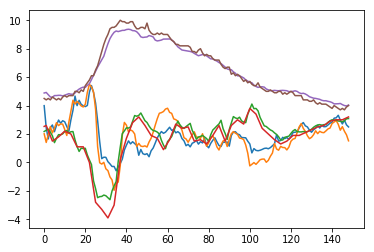

In [10]:
def evaluate_on_test(testloader: DataLoader, net: nn.Module, criterion: nn.MSELoss):
    y_pred = []
    y_act = []
    running_test_loss = []
    
    for i, data in enumerate(testloader):
        with torch.no_grad():
            y, X = data
            y, X = y.float(), X.float()
            
            loss = criterion(y, net(X))
            running_test_loss.append(loss.item())
        
            y_pred.append(net(X)[0].item())
            y_act.append(y[0].item())
        
    plt.plot(y_pred)
    plt.plot(y_act)
    
    return get_average(running_test_loss)
    
total_mse = 0
    
for i in range(3):
    average_mse = evaluate_on_test(testloaders[i], nets[i], criteria[i])
    total_mse += average_mse
    print("Average MSE on test set: " + str(average_mse))
    
print("Total MSE: " + str(total_mse))